# Graphical Method: FOPDT to Step Test

A first-order linear system with time delay is a common empirical description of many stable dynamic processes. The equation

$$\tau_p \frac{dy(t)}{dt} = -y(t) + K_p u\left(t-\theta_p\right)$$

has variables $y(t)$ and $u(t)$ and three unknown parameters.

$$K_p \quad \mathrm{= Process \; gain}$$
$$\tau_p \quad \mathrm{= Process \; time \; constant}$$
$$\theta_p \quad \mathrm{= Process \; dead \; time}$$

Step test data are convenient for identifying an FOPDT model through a graphical fitting method. Follow the following steps when fitting the parameters $K_{p}, \tau_{p}, \theta_{p}$ to a step response.

1. Find $\Delta y$ from step response
2. Find $\Delta u$ from step response
3. Calculate $K_p = {\Delta y} / {\Delta u}$
4. Find $\theta_{p}$, apparent dead time, from step response
5. Find $0.632\Delta y$ from step response
6. Find $t_{0.632}$ for $y(t_{0.632}) = 0.632 \Delta y$ from step response
7. Calculate $\tau_{p}=t_{0.632} − \theta_{p}$. This assumes that the step starts at $t=0$. If the step happens later, subtract the step time as well.

### Exercise

Use the above steps to find parameters $K_{p}, \tau_{p}$, and $\theta_{p}$. Insert the updated parameters in the code and rerun the script to observe quality of the graphical fit in agreement with the simulated process data.

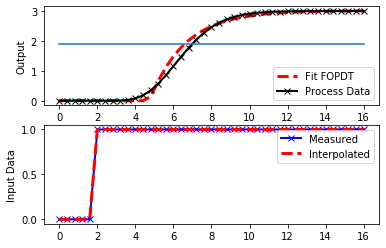

In [17]:
# Import modules
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from scipy.optimize import minimize
from scipy.interpolate import interp1d

# define process model (to generate process data)
def process(y,t,n,u,Kp,taup):
    # arguments
    #  y[n] = outputs
    #  t    = time
    #  n    = order of the system  
    #  u    = input value
    #  Kp   = process gain
    #  taup = process time constant

    # equations for higher order system
    dydt = np.zeros(n)

    # calculate derivative
    dydt[0] = (-y[0] + Kp * u)/(taup/n)
    for i in range(1,n):
       dydt[i] = (-y[i] + y[i-1])/(taup/n)
    return dydt

# define first-order plus dead-time approximation    
def fopdt(y,t,uf,Km,taum,thetam):
    # arguments
    #  y      = output
    #  t      = time
    #  uf     = input linear function (for time shift)
    #  Km     = model gain
    #  taum   = model time constant
    #  thetam = model time constant

    # time-shift u
    try:
        if (t-thetam) <= 0:
            um = uf(0.0)
        else:
            um = uf(t-thetam)
    except:
        print('Error with time extrapolation: ' + str(t))
        um = 0

    # calculate derivative
    dydt = (-y + Km * um)/taum
    return dydt

# specify number of steps
ns = 40

# define time points
t = np.linspace(0,16,ns+1)
delta_t = t[1]-t[0]

# Define input vector
u = np.zeros(ns+1)
u[5:] = 1.0

# Create linear interpolation of the u data versus time
uf = interp1d(t, u)

# Use this function or replace yp with real process data
def sim_process_data():
    # higher order process
    n=10       # order
    Kp=3.0    # gain
    taup=5.0   # time constant
    # storage for predictions or data
    yp = np.zeros(ns+1)  # process
    for i in range(1,ns+1):
        if i==1:
            yp0 = np.zeros(n)
        ts = [delta_t*(i-1),delta_t*i]
        y = odeint(process,yp0,ts,args=(n,u[i],Kp,taup))
        yp0 = y[-1]
        yp[i] = y[1][n-1]
    return yp

# Simulate process data
yp = sim_process_data()

# Simulate FOPDT model with x=[Km,taum,thetam]
def sim_model(Km,taum,thetam):
    # input arguments
    #Km
    #taum
    #thetam

    # storage for model values
    ym = np.zeros(ns+1)  # model

    # initial condition
    ym[0] = 0

    # loop through time steps    
    for i in range(1,ns+1):
        ts = [delta_t*(i-1),delta_t*i]
        y1 = odeint(fopdt,ym[i-1],ts,args=(uf,Km,taum,thetam))
        ym[i] = y1[-1]
    return ym    

# Calculate model with updated parameters
Km = 3.0145
taum = 1.8586
thetam = 2.9367
ym = sim_model(Km,taum,thetam)

# plot results
plt.figure()
plt.subplot(2,1,1)
plt.plot(t,ym,'r--',linewidth=3,label='Fit FOPDT')
plt.plot(t,yp,'kx-',linewidth=2,label='Process Data')
plt.plot(t, [0.632*3]*len(t))
plt.ylabel('Output')
plt.legend(loc='best')
plt.subplot(2,1,2)
plt.plot(t,u,'bx-',linewidth=2)
plt.plot(t,uf(t),'r--',linewidth=3)
plt.legend(['Measured','Interpolated'],loc='best')
plt.ylabel('Input Data')
plt.show()